In [2]:
import os
import sys 
import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import regularizers
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow.keras.backend as K

from tensorflow.keras import Input
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.layers import Attention #from attention import Attention

import plotly
import plotly.graph_objects as go
import plotly.express as px
import kaleido ##pip install -U kaleido ##to save a plotly fig
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_val_score,cross_val_predict

In [6]:
df = pd.read_csv('longitudinal behavioral data.csv')
df=df.drop(['subject','2weeks_class','1month_class','2months_class','3months_class'],axis=1)
print(len(df))
#df.dtypes[df.dtypes==object]
df['Annoying.4'] = df['Annoying.4'].replace('.', 2)
df['Annoying.4'] = df['Annoying.4'].astype('float32')
#df.columns.get_loc("3months_TFI") -->80

18


In [7]:
## Separate dependent and independent features 
X=df.iloc[:,:80].values
y=df.iloc[:,-20:].values

In [9]:
# with scaled data
n_epochs=100
n_batch_size=6 #batch training
n_timesteps=4
n_features=20
lr=0.01
kfold = KFold(n_splits=5)
error_scores=[]

"""
    Reshape rule:
    tensor of shape (batch size, sequence length, features), 
    where sequence length is the number of time steps and features is each input timeseries.
"""

# Reshape input to be [batch size, sequence length, features]
X = X.reshape((X.shape[0],n_timesteps,n_features))
print(X.shape,y.shape)
input_shape=(n_timesteps,n_features)
print(input_shape)


"""
Include residual connections, layer normalization, and dropout.
The resulting layer can be stacked multiple times.
The projection layers are implemented through `keras.layers.Conv1D`.
"""

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Attention and Normalization
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(inputs, inputs)
    x = layers.Dropout(dropout)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.Dense(ff_dim, activation="relu")(res)
    x = layers.Dropout(dropout)(x)
    x = layers.Dense(units=inputs.shape[-1])(x) 
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    return x + res


def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    K.clear_session()
    inputs = keras.Input(shape=input_shape)
    x = inputs
    
    """    
    can stack multiple of the transformer_encoder blocks and 
    can also proceed to add the final Multi-Layer Perceptron regression head.
    """
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)
    
    """
    a pooling layer is used to to reduce the output tensor of the TransformerEncoder 
    part of our model down to a vector of features for each data point in the current batch.
    """
    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x) 
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(1, activation="linear")(x)
    return keras.Model(inputs, outputs)

def prediction(x_train,y_train):
    input_shape = x_train.shape[1:]

    model = build_model(
        input_shape,
        head_size=5, # Embedding size for each token #key_dim
        num_heads=4, # Number of attention heads
        ff_dim=5, # Hidden layer size in feed forward network inside transformer
        num_transformer_blocks=4,
        mlp_units=[128],
        mlp_dropout=0.4,
        dropout=0.25,
    )
    model.compile(
        loss="mae",
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        #metrics=[keras.metrics.MeanAbsoluteError()],

    )
    
    return model

def cross_val(df,error_scores):
    #X,y,input_shape,x_scaler,y_scaler=data_prep(df)
    for train_index, test_index in kfold.split(X):
        print("TRAIN:", train_index, "TEST:", test_index)
        x_train, x_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        model=prediction(x_train,y_train)
        history=model.fit(x_train, y_train,epochs=n_epochs,batch_size=n_batch_size,validation_split=0.2,verbose =1)#validation_data=(x_test,y_test) #validation_split=0.2
        #val_mse,val_mae=model.evaluate(x_test,y_test)
        #error_scores.append(val_mae)
        val_mae=model.evaluate(x_test,y_test)
        error_scores.append(val_mae)
    return history,error_scores

history,error_scores=cross_val(df,error_scores)

    

(18, 4, 20) (18, 20)
(4, 20)
TRAIN: [ 4  5  6  7  8  9 10 11 12 13 14 15 16 17] TEST: [0 1 2 3]
Epoch 1/100


2022-06-09 06:56:39.186678: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - ETA: 0s - loss: 14.8973

2022-06-09 06:56:40.599146: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 3s 725ms/step - loss: 14.8973 - val_loss: 27.1682
Epoch 2/100
2/2 [==============================] - 0s 115ms/step - loss: 13.9969 - val_loss: 25.2222
Epoch 3/100
2/2 [==============================] - 0s 110ms/step - loss: 14.1368 - val_loss: 23.6188
Epoch 4/100
2/2 [==============================] - 0s 95ms/step - loss: 12.6503 - val_loss: 22.2554
Epoch 5/100
2/2 [==============================] - 0s 112ms/step - loss: 12.5478 - val_loss: 21.3212
Epoch 6/100
2/2 [==============================] - 0s 104ms/step - loss: 11.9266 - val_loss: 20.9888
Epoch 7/100
2/2 [==============================] - 0s 90ms/step - loss: 11.0308 - val_loss: 20.8440
Epoch 8/100
2/2 [==============================] - 0s 91ms/step - loss: 10.5842 - val_loss: 20.7635
Epoch 9/100
2/2 [==============================] - 0s 98ms/step - loss: 10.7427 - val_loss: 20.6978
Epoch 10/100
2/2 [==============================] - 0s 94ms/step - loss: 11.1123 - val_loss: 20.6575
Epoch 

2/2 [==============================] - 0s 81ms/step - loss: 10.5328 - val_loss: 20.7671
Epoch 83/100
2/2 [==============================] - 0s 81ms/step - loss: 10.4433 - val_loss: 20.7625
Epoch 84/100
2/2 [==============================] - 0s 85ms/step - loss: 10.5312 - val_loss: 20.7629
Epoch 85/100
2/2 [==============================] - 0s 85ms/step - loss: 10.4480 - val_loss: 20.7653
Epoch 86/100
2/2 [==============================] - 0s 81ms/step - loss: 10.5892 - val_loss: 20.7722
Epoch 87/100
2/2 [==============================] - 0s 77ms/step - loss: 10.5585 - val_loss: 20.7745
Epoch 88/100
2/2 [==============================] - 0s 81ms/step - loss: 10.4842 - val_loss: 20.7744
Epoch 89/100
2/2 [==============================] - 0s 79ms/step - loss: 10.4800 - val_loss: 20.7737
Epoch 90/100
2/2 [==============================] - 0s 79ms/step - loss: 10.3886 - val_loss: 20.7748
Epoch 91/100
2/2 [==============================] - 0s 77ms/step - loss: 10.4478 - val_loss: 20.7733
Epo

2022-06-09 06:56:56.384504: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - ETA: 0s - loss: 18.3667

2022-06-09 06:56:57.879581: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 3s 746ms/step - loss: 18.3667 - val_loss: 32.4495
Epoch 2/100
2/2 [==============================] - 0s 125ms/step - loss: 17.0994 - val_loss: 30.4496
Epoch 3/100
2/2 [==============================] - 0s 125ms/step - loss: 15.6875 - val_loss: 28.4725
Epoch 4/100
2/2 [==============================] - 0s 100ms/step - loss: 14.7812 - val_loss: 26.5393
Epoch 5/100
2/2 [==============================] - 0s 106ms/step - loss: 14.1349 - val_loss: 24.7835
Epoch 6/100
2/2 [==============================] - 0s 101ms/step - loss: 11.9782 - val_loss: 23.3268
Epoch 7/100
2/2 [==============================] - 0s 105ms/step - loss: 11.4691 - val_loss: 22.0648
Epoch 8/100
2/2 [==============================] - 0s 92ms/step - loss: 11.0379 - val_loss: 21.2653
Epoch 9/100
2/2 [==============================] - 0s 92ms/step - loss: 10.7277 - val_loss: 20.9939
Epoch 10/100
2/2 [==============================] - 0s 86ms/step - loss: 10.0736 - val_loss: 20.8648
Epoc

Epoch 83/100
2/2 [==============================] - 0s 83ms/step - loss: 9.9086 - val_loss: 20.6589
Epoch 84/100
2/2 [==============================] - 0s 83ms/step - loss: 9.8787 - val_loss: 20.6603
Epoch 85/100
2/2 [==============================] - 0s 83ms/step - loss: 9.8448 - val_loss: 20.6667
Epoch 86/100
2/2 [==============================] - 0s 87ms/step - loss: 9.8609 - val_loss: 20.6698
Epoch 87/100
2/2 [==============================] - 0s 85ms/step - loss: 9.8805 - val_loss: 20.6724
Epoch 88/100
2/2 [==============================] - 0s 83ms/step - loss: 9.7878 - val_loss: 20.6732
Epoch 89/100
2/2 [==============================] - 0s 84ms/step - loss: 9.7640 - val_loss: 20.6731
Epoch 90/100
2/2 [==============================] - 0s 82ms/step - loss: 9.8131 - val_loss: 20.6738
Epoch 91/100
2/2 [==============================] - 0s 81ms/step - loss: 9.7586 - val_loss: 20.6756
Epoch 92/100
2/2 [==============================] - 0s 85ms/step - loss: 9.7997 - val_loss: 20.6752


2022-06-09 06:57:13.937175: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - ETA: 0s - loss: 10.7353

2022-06-09 06:57:15.500876: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 3s 811ms/step - loss: 10.7353 - val_loss: 22.0599
Epoch 2/100
2/2 [==============================] - 0s 126ms/step - loss: 10.7773 - val_loss: 21.3341
Epoch 3/100
2/2 [==============================] - 0s 102ms/step - loss: 10.4317 - val_loss: 21.0476
Epoch 4/100
2/2 [==============================] - 0s 131ms/step - loss: 10.2498 - val_loss: 20.8975
Epoch 5/100
2/2 [==============================] - 0s 103ms/step - loss: 10.5570 - val_loss: 20.8161
Epoch 6/100
2/2 [==============================] - 0s 104ms/step - loss: 9.8556 - val_loss: 20.7494
Epoch 7/100
2/2 [==============================] - 0s 91ms/step - loss: 10.2101 - val_loss: 20.7147
Epoch 8/100
2/2 [==============================] - 0s 101ms/step - loss: 9.6292 - val_loss: 20.7009
Epoch 9/100
2/2 [==============================] - 0s 89ms/step - loss: 9.7637 - val_loss: 20.6959
Epoch 10/100
2/2 [==============================] - 0s 95ms/step - loss: 10.4581 - val_loss: 20.6918
Epoch 1

Epoch 83/100
2/2 [==============================] - 0s 86ms/step - loss: 9.5777 - val_loss: 20.5907
Epoch 84/100
2/2 [==============================] - 0s 87ms/step - loss: 9.5326 - val_loss: 20.5889
Epoch 85/100
2/2 [==============================] - 0s 83ms/step - loss: 9.4992 - val_loss: 20.5867
Epoch 86/100
2/2 [==============================] - 0s 81ms/step - loss: 9.5177 - val_loss: 20.5854
Epoch 87/100
2/2 [==============================] - 0s 85ms/step - loss: 9.5764 - val_loss: 20.5834
Epoch 88/100
2/2 [==============================] - 0s 86ms/step - loss: 9.5302 - val_loss: 20.5837
Epoch 89/100
2/2 [==============================] - 0s 87ms/step - loss: 9.5499 - val_loss: 20.5821
Epoch 90/100
2/2 [==============================] - 0s 82ms/step - loss: 9.5342 - val_loss: 20.5785
Epoch 91/100
2/2 [==============================] - 0s 85ms/step - loss: 9.5341 - val_loss: 20.5742
Epoch 92/100
2/2 [==============================] - 0s 86ms/step - loss: 9.5197 - val_loss: 20.5706


2022-06-09 06:57:31.312973: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - ETA: 0s - loss: 12.9111

2022-06-09 06:57:32.475515: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 3s 578ms/step - loss: 12.9111 - val_loss: 24.1635
Epoch 2/100
2/2 [==============================] - 0s 106ms/step - loss: 12.1465 - val_loss: 22.9962
Epoch 3/100
2/2 [==============================] - 0s 122ms/step - loss: 11.5796 - val_loss: 21.9488
Epoch 4/100
2/2 [==============================] - 0s 97ms/step - loss: 11.5319 - val_loss: 21.2812
Epoch 5/100
2/2 [==============================] - 0s 103ms/step - loss: 10.6288 - val_loss: 20.9962
Epoch 6/100
2/2 [==============================] - 0s 81ms/step - loss: 10.7125 - val_loss: 20.8528
Epoch 7/100
2/2 [==============================] - 0s 77ms/step - loss: 9.9911 - val_loss: 20.7778
Epoch 8/100
2/2 [==============================] - 0s 78ms/step - loss: 10.1775 - val_loss: 20.7126
Epoch 9/100
2/2 [==============================] - 0s 74ms/step - loss: 10.2065 - val_loss: 20.6568
Epoch 10/100
2/2 [==============================] - 0s 89ms/step - loss: 10.3776 - val_loss: 20.6390
Epoch 11

Epoch 83/100
2/2 [==============================] - 0s 66ms/step - loss: 9.8939 - val_loss: 20.6314
Epoch 84/100
2/2 [==============================] - 0s 75ms/step - loss: 9.8618 - val_loss: 20.6312
Epoch 85/100
2/2 [==============================] - 0s 75ms/step - loss: 9.8280 - val_loss: 20.6309
Epoch 86/100
2/2 [==============================] - 0s 75ms/step - loss: 9.8860 - val_loss: 20.6309
Epoch 87/100
2/2 [==============================] - 0s 68ms/step - loss: 9.9535 - val_loss: 20.6308
Epoch 88/100
2/2 [==============================] - 0s 70ms/step - loss: 9.9333 - val_loss: 20.6309
Epoch 89/100
2/2 [==============================] - 0s 71ms/step - loss: 9.9052 - val_loss: 20.6309
Epoch 90/100
2/2 [==============================] - 0s 70ms/step - loss: 9.8495 - val_loss: 20.6310
Epoch 91/100
2/2 [==============================] - 0s 68ms/step - loss: 9.9091 - val_loss: 20.6310
Epoch 92/100
2/2 [==============================] - 0s 69ms/step - loss: 9.8212 - val_loss: 20.6302


2022-06-09 06:57:44.816629: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - ETA: 0s - loss: 16.8220

2022-06-09 06:57:46.074626: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 2s 597ms/step - loss: 16.8220 - val_loss: 15.9993
Epoch 2/100
2/2 [==============================] - 0s 138ms/step - loss: 15.7625 - val_loss: 15.1491
Epoch 3/100
2/2 [==============================] - 0s 126ms/step - loss: 14.8328 - val_loss: 14.3196
Epoch 4/100
2/2 [==============================] - 0s 79ms/step - loss: 13.5109 - val_loss: 13.5001
Epoch 5/100
2/2 [==============================] - 0s 95ms/step - loss: 12.2567 - val_loss: 12.7030
Epoch 6/100
2/2 [==============================] - 0s 91ms/step - loss: 11.9804 - val_loss: 12.0100
Epoch 7/100
2/2 [==============================] - 0s 101ms/step - loss: 11.0759 - val_loss: 11.4692
Epoch 8/100
2/2 [==============================] - 0s 86ms/step - loss: 10.7530 - val_loss: 11.0032
Epoch 9/100
2/2 [==============================] - 0s 74ms/step - loss: 10.3988 - val_loss: 10.6455
Epoch 10/100
2/2 [==============================] - 0s 72ms/step - loss: 10.3198 - val_loss: 10.4508
Epoch 1

2/2 [==============================] - 0s 72ms/step - loss: 10.0680 - val_loss: 10.1967
Epoch 83/100
2/2 [==============================] - 0s 70ms/step - loss: 10.0441 - val_loss: 10.1992
Epoch 84/100
2/2 [==============================] - 0s 70ms/step - loss: 10.0002 - val_loss: 10.2007
Epoch 85/100
2/2 [==============================] - 0s 69ms/step - loss: 9.9788 - val_loss: 10.2022
Epoch 86/100
2/2 [==============================] - 0s 66ms/step - loss: 10.0334 - val_loss: 10.2052
Epoch 87/100
2/2 [==============================] - 0s 65ms/step - loss: 9.9711 - val_loss: 10.2066
Epoch 88/100
2/2 [==============================] - 0s 68ms/step - loss: 10.0058 - val_loss: 10.2076
Epoch 89/100
2/2 [==============================] - 0s 70ms/step - loss: 9.9476 - val_loss: 10.2068
Epoch 90/100
2/2 [==============================] - 0s 66ms/step - loss: 10.0381 - val_loss: 10.2063
Epoch 91/100
2/2 [==============================] - 0s 67ms/step - loss: 9.9519 - val_loss: 10.2059
Epoch 9

In [10]:
print("error")
print(error_scores)
error=np.mean(error_scores)
print("\n")
print(error)

error
[8.692800521850586, 10.455135345458984, 11.586532592773438, 10.123847007751465, 20.745262145996094]


12.320715522766113


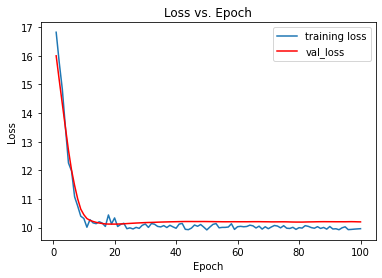

In [18]:
def plot_loss(history):
        train_loss=history.history['loss']
        val_loss=history.history['val_loss']
        x=list(range(1,len(val_loss)+1))
        plt.plot(x,train_loss,label='training loss')
        plt.plot(x,val_loss,color='red',label='val_loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Loss vs. Epoch')
        plt.legend()

plot_loss(history)